## Bibliotecas

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl as opx
import scipy.optimize as scy
from lmfit import Model

## Importando Arquivo de dados


In [26]:
df=pd.read_excel(r'E:\eduro\Documents\Graduação ITA\Iniciação científica\Dados-impedancia.xlsx')

In [27]:
#importando excel
wb=opx.load_workbook(r'E:\eduro\Documents\Graduação ITA\Iniciação científica\Dados-impedancia.xlsx')
#abrindo página de localização da tabela
ws=wb['arg03']

In [28]:
def create_df_from_excel(ws,nome_da_tabela):
    mapping = {}

    for entry, data_boundary in ws.tables.items():
        #parse the data within the ref boundary
        data = ws[data_boundary]
        #extract the data 
        #the inner list comprehension gets the values for each cell in the table
        content = [[cell.value for cell in ent] 
                for ent in data
            ]
        header = content[0]
        #the contents ... excluding the header
        rest = content[1:]
        #create dataframe with the column names
        #and pair table name with dataframe
        df = pd.DataFrame(rest, columns = header)
        mapping[entry] = df
    return mapping[nome_da_tabela]


In [29]:
df=create_df_from_excel(ws,'Ref_03')
df.dropna(how='all',inplace=True)

In [30]:
df.rename(columns={'Column1':'Frequency','Column2':'Impedance','Column3':'Phase'},inplace=True)
df.drop(columns={'Column4','Column5'},inplace=True)

## Criação de Colunas


In [31]:
df['Phase_Rad']=np.radians(df['Phase'])
df.rename(columns={'Phase':'Phase_degree'},inplace=True)

In [32]:
df['Omega']=2*np.pi*df['Frequency']

In [33]:
df['Impedance_Real']=df['Impedance']*np.cos(df['Phase_Rad'])
df['Impedance_Imaginary']=np.abs(df['Impedance']*np.sin(df['Phase_Rad']))

Text(0, 0.5, 'Impedância Imaginária')

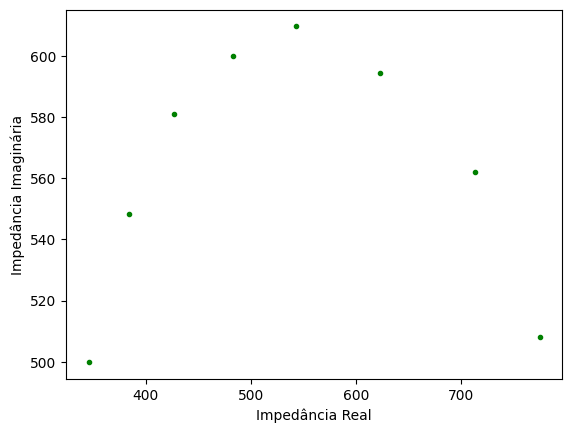

In [34]:
fig, axs = plt.subplots(1, 1)
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'g.')
plt.xlabel('Impedância Real')
plt.ylabel('Impedância Imaginária')

In [35]:
def func_real(w,R,t,a):
    f=R*(1+np.cos((1-a)*np.pi/2)*(w*t)**(1-a))/(1+ (w*t)**(2-2*a) +2*np.cos((1-a)*np.pi/2)*(w*t)**(1-a))
    return f
def func_im(w,R,t,a):
    f=np.abs(-1*R*(np.sin((1-a)*np.pi/2)*(w*t)**(1-a))/(1+ (w*t)**(2-2*a) +2*np.cos((1-a)*np.pi/2)*(w*t)**(1-a)))
    return f
def impd(w,R,t,a):
    f=func_real(w,R,t,a)+1j*func_im(w,R,t,a)
    return f

def impd2(w,R,t,a):
    f=R/(1+(1j*w*t)**(1-a))
    return f
def modulo(w,R,t,a=10**-2):
    f=np.sqrt(func_real(w,R,t,a)**2+func_im(w,R,t,a)**2)    
    return f

## Fit pela função complexa

In [36]:
df.imp=df.Impedance_Real + 1j*df.Impedance_Imaginary
popt, pcov = scy.curve_fit(impd2, df.Omega, df.imp,bounds=([0,0,0],[2000,10**-2,0.209]),p0=[950,10**-10,0.0109],maxfev=100000)

C:\Users\eduro\AppData\Local\Temp\ipykernel_14532\1670188572.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.imp=df.Impedance_Real + 1j*df.Impedance_Imaginary
c:\Users\eduro\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\series.py:893: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._values, dtype)
c:\Users\eduro\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
c:\Users\eduro\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_lsq\trf.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  f_augmented[:m] = f
c:\Users\eduro\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_

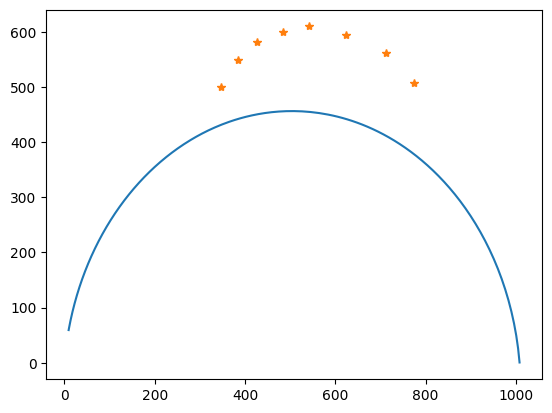

In [37]:
xx=np.linspace(10**3,8*10**7,1000)
z_im=func_im(xx,*popt)
z_real=func_real(xx,*popt)
plt.plot(abs(z_real),abs(z_im))
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'*')

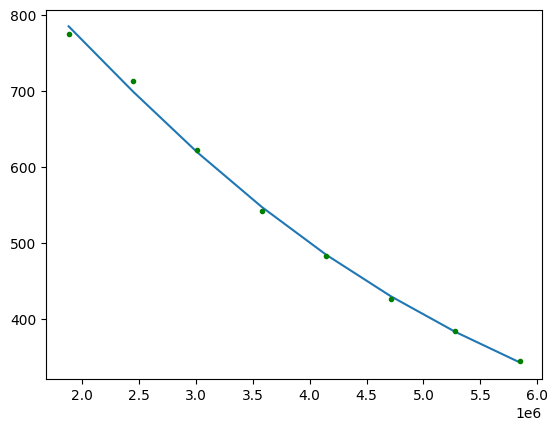

In [38]:
plt.plot(df.Omega,func_real(df.Omega,*popt))
plt.plot(df.Omega,df['Impedance_Real'],'g.')

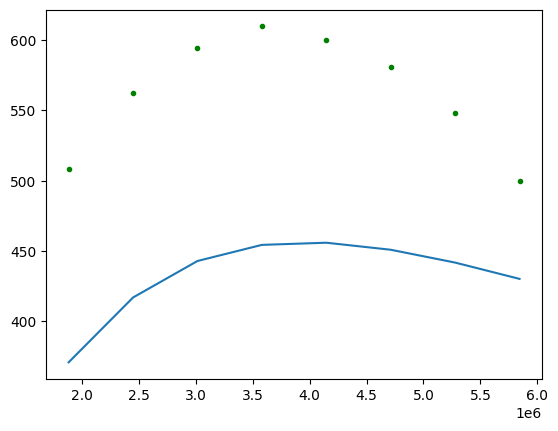

In [39]:
plt.plot(df.Omega,func_im(df.Omega,*popt))
plt.plot(df.Omega,df['Impedance_Imaginary'],'g.')

## Fits separados


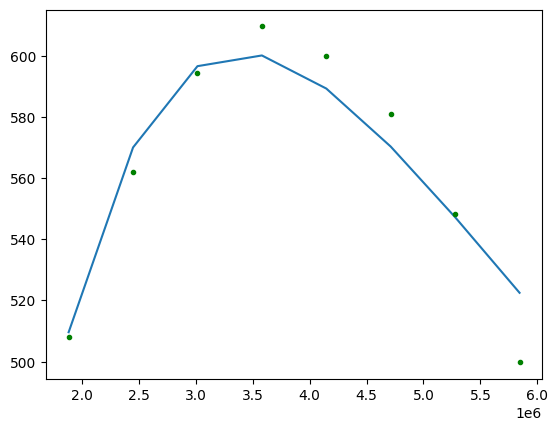

In [40]:
popt_im, pcov = scy.curve_fit(func_im, df.Omega, df.Impedance_Imaginary,bounds=([0,0,0],[2000,10**-2,0.209]),p0=[950,10**-10,0.0109],maxfev=100000)
plt.plot(df.Omega,func_im(df.Omega,*popt_im))
plt.plot(df.Omega,df['Impedance_Imaginary'],'g.')

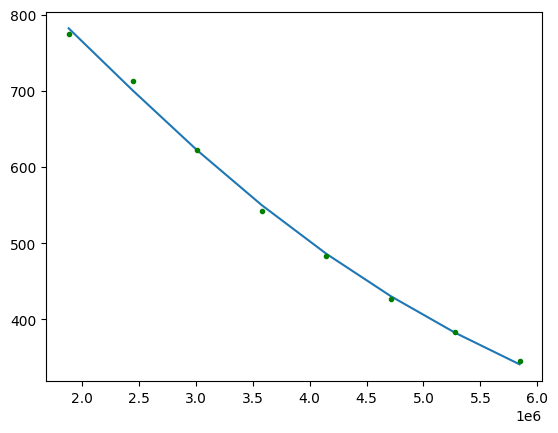

In [41]:
popt_real, pcov = scy.curve_fit(func_real, df.Omega, df.Impedance_Real,bounds=([0,0,0],[2000,10**-2,0.209]),maxfev=100000)
plt.plot(df.Omega,func_real(df.Omega,*popt_real))
plt.plot(df.Omega,df['Impedance_Real'],'g.')

## Fit pela função módulo

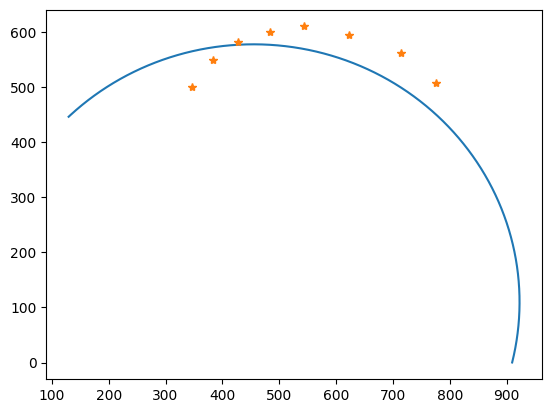

In [52]:
popt_mod, pcov = scy.curve_fit(modulo, df.Omega, df.Impedance,p0=[900,10**-7,0.5],method='lm',maxfev=100000)
xx=np.linspace(10**3,8*10**6,1000000)
z_im=func_im(xx,*popt_mod)
z_real=func_real(xx,*popt_mod)
plt.plot(abs(z_real),abs(z_im))
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'*')

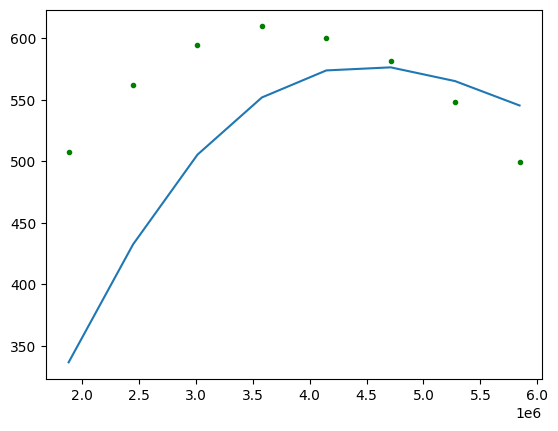

In [43]:
plt.plot(df.Omega,func_im(df.Omega,*popt_mod))
plt.plot(df.Omega,df['Impedance_Imaginary'],'g.')

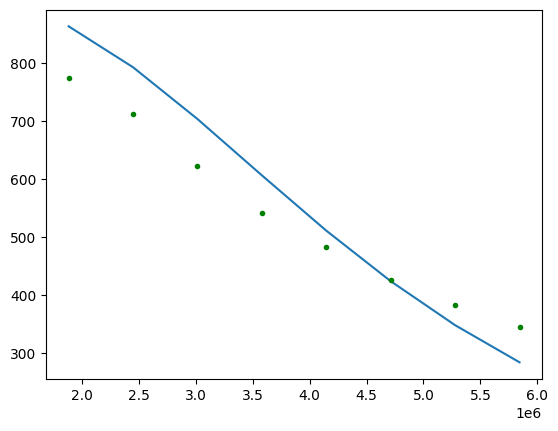

In [44]:
plt.plot(df.Omega,func_real(df.Omega,*popt_mod))
plt.plot(df.Omega,df['Impedance_Real'],'g.')

## supondo a=0.1

In [45]:
def func_real_a(w,R,t):
    f=R*(1+np.cos((1-10**-4)*np.pi/2)*(w*t)**(1-10**-4))/(1+ (w*t)**(2-2*10**-4) +2*np.cos((1-10**-4)*np.pi/2)*(w*t)**(1-10**-4))
    return f
def func_im_a(w,R,t):
    f=np.abs(-1*R*(np.sin((1-10**-4)*np.pi/2)*(w*t)**(1-10**-4))/(1+ (w*t)**(2-2*10**-4) +2*np.cos((1-10**-4)*np.pi/2)*(w*t)**(1-10**-4)))
    return f
def modulo_a(w,R,t):
    f=np.sqrt(func_real_a(w,R,t)**2+func_im_a(w,R,t)**2)    
    return f

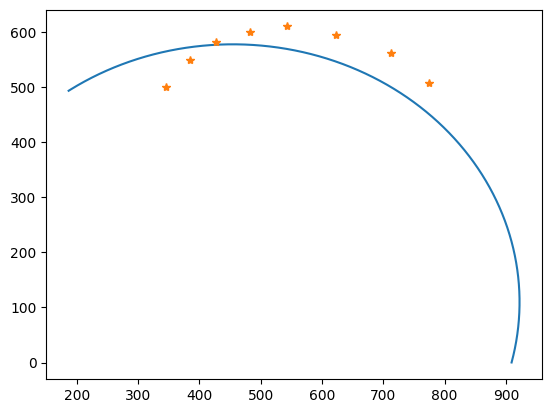

In [46]:
popt_moda, pcov = scy.curve_fit(modulo_a, df.Omega, df.Impedance,p0=[50000,10**-5],method='lm',maxfev=100000)
xx=np.linspace(10**3,7*10**6,1000000)
z_im=func_im(xx,*popt_mod)
z_real=func_real(xx,*popt_mod)
plt.plot(abs(z_real),abs(z_im))
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'*')

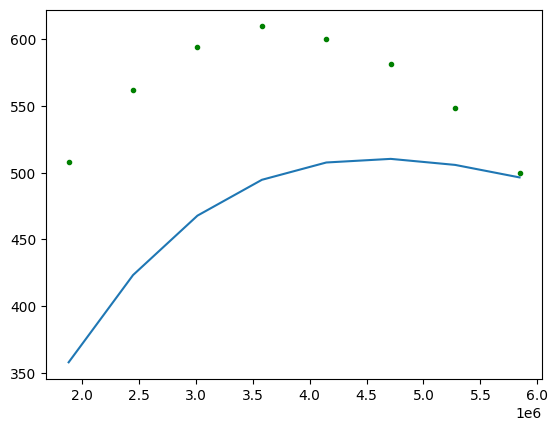

In [47]:
plt.plot(df.Omega,func_im_a(df.Omega,*popt_moda))
plt.plot(df.Omega,df['Impedance_Imaginary'],'g.')

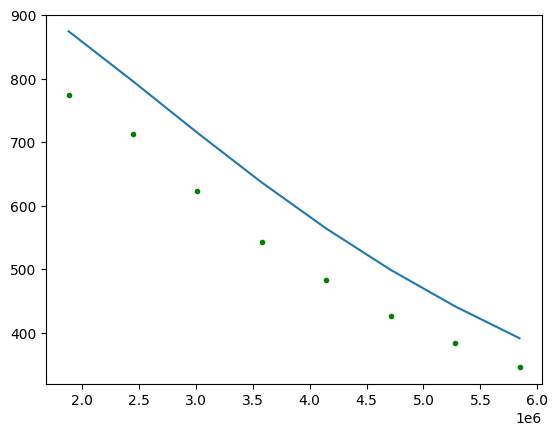

In [48]:
plt.plot(df.Omega,func_real_a(df.Omega,*popt_moda))
plt.plot(df.Omega,df['Impedance_Real'],'g.')

In [60]:
def func_real_r(w,t,a):
    f=850*(1+np.cos((1-a)*np.pi/2)*(w*t)**(1-a))/(1+ (w*t)**(2-2*a) +2*np.cos((1-a)*np.pi/2)*(w*t)**(1-a))
    return f
def func_im_r(w,t,a):
    f=np.abs(-1*850*(np.sin((1-a)*np.pi/2)*(w*t)**(1-a))/(1+ (w*t)**(2-2*a) +2*np.cos((1-a)*np.pi/2)*(w*t)**(1-a)))
    return f
def modulo_r(w,t,a):
    f=np.sqrt(func_real_r(w,t,a)**2+func_im_r(w,t,a)**2)    
    return f

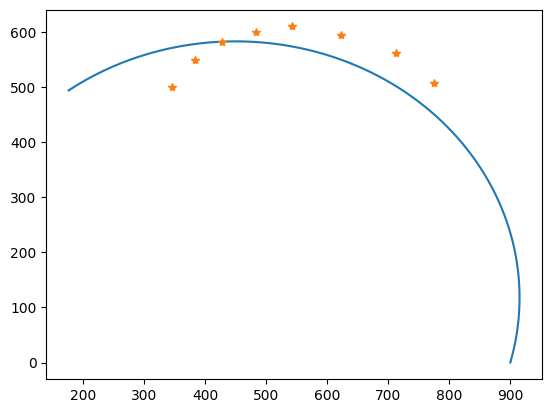

In [55]:
popt_mod_r, pcov = scy.curve_fit(modulo_r, df.Omega, df.Impedance,p0=[10**-7,0.5],method='lm',maxfev=100000)
xx=np.linspace(10**3,7*10**6,1000000)
z_im=func_im_r(xx,*popt_mod_r)
z_real=func_real_r(xx,*popt_mod_r)
plt.plot(abs(z_real),abs(z_im))
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'*')

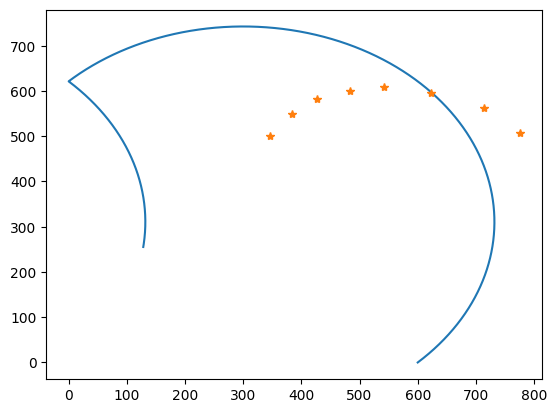

In [59]:
popt_mod_r, pcov = scy.curve_fit(modulo_r, df.Omega, df.Impedance,p0=[10**-7,0.5],method='lm',maxfev=100000)
xx=np.linspace(10**3,7*10**6,1000000)
z_im=func_im_r(xx,*popt_mod_r)
z_real=func_real_r(xx,*popt_mod_r)
plt.plot(abs(z_real),abs(z_im))
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'*')

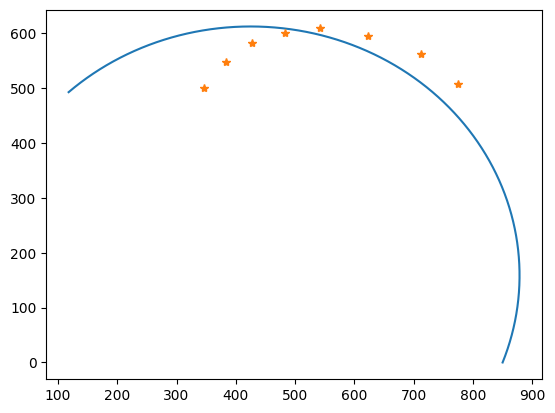

In [61]:
popt_mod_r, pcov = scy.curve_fit(modulo_r, df.Omega, df.Impedance,p0=[10**-7,0.5],method='lm',maxfev=100000)
xx=np.linspace(10**3,7*10**6,1000000)
z_im=func_im_r(xx,*popt_mod_r)
z_real=func_real_r(xx,*popt_mod_r)
plt.plot(abs(z_real),abs(z_im))
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'*')